<a href="https://colab.research.google.com/github/befitz/ISOM837_AnalyticsStoryTelling/blob/main/ISOM837_AnalyticsStoryTelling_IQuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader
from pandas_datareader import data as web
import datetime as dt
from functools import reduce
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

end = dt.datetime.today()
start = (dt.datetime.now() - dt.timedelta(days = 36500)).strftime("%m-%d-%Y")
dfs = []
def get_fed_data(DataSetName):
  """
  Function to retreive the given datasetname from the FRED API
  args: DataSetName (list)
  returns: fred_data (pd.DataFrame)
  """
  for name in DataSetName:
    fred = web.DataReader(f'{name}', 'fred', start, end)
    fred = fred.reset_index()
    fred = fred.rename(columns={'DATE':'Date'})
    dfs.append(fred)
  final_fred = reduce(lambda left,right: pd.merge(left, right, on=['Date'], how = 'outer'), dfs)

  return final_fred


variables = ['CES0000000039', 'LCEAPR01USM189S', 'LNS12027714',
             'TCU', 'USEPUINDXM', 'AWHNONAG', 'LNU01300012','LNS11300060','LNS11324230','JTS1000QUR', 'CPIAUCSL', 'JTSJOR']

columnNames = {'TCU': 'cap_utilization',
               'USEPUINDXM': 'policy_uncertainty',
               'CES0000000039': 'women_ratio',
               'LCEAPR01USM189S': 'hourly_earn',
               'AWHNONAG': 'hours_worked',
               'LNU01300012': 'lfp_16_19',
               'LNS11300060': 'lfp_25_54',
               'LNS11324230': 'lfp_0ver55',
               'LNS12027714': 'self_employed',
               'JTS1000QUR': 'quits',
               'CPIAUCSL': 'cpi',
               'JTSJOR':'job_openings'}


def build_seperations_table(variables):
  """
  Function to call the get_fed_data function and columns to create the RAW dataset
  args: variables (list)
  returns: table_raw (pd.DataFrame)
  """
  table_raw = get_fed_data(variables)
  table_raw = table_raw.rename(columns = columnNames)
  table_raw = table_raw.dropna()

  return table_raw


table_raw = build_seperations_table(variables)


class Test_Values():
  """
  This class is to provide values for the variables WITHOUT transformation. These values are from the RAW data.
  """
  def __init__(self, series):
    self.std = np.std(series)
    self.median = np.median(series)
    self.mean = np.mean(series)
    self.test_val1 = series.iloc[-5] - series.iloc[-6]
    self.test_val2 = series.iloc[-4] - series.iloc[-5]
    self.test_val3 = series.iloc[-3] - series.iloc[-4]
    self.test_val4 = series.iloc[-2] - series.iloc[-3]
    self.test_val5 = series.iloc[-1] - series.iloc[-2]
    self.min = np.min(series)
    self.max = np.max(series)
    self.min_max = (np.min(series) - np.max(series))/ (np.max(series) - np.min(series))
    self.max_minY = (np.max(series) - np.min(series))/ (np.max(table_raw['quits'][:235]) - np.min(table_raw['quits'][:235]))

women_ratio = Test_Values(table_raw['women_ratio'])
hourly_earn = Test_Values(table_raw['hourly_earn'])
lfp_25_54 = Test_Values(table_raw['lfp_25_54'])
lfp_16_19 = Test_Values(table_raw['lfp_16_19'])
lfp_0ver55 = Test_Values(table_raw['lfp_0ver55'])
cap_utilization = Test_Values(table_raw['cap_utilization'])
hours_worked = Test_Values(table_raw['hours_worked'])
cpi = Test_Values(table_raw['cpi'])
self_employed= Test_Values(table_raw['self_employed'])
policy_uncertainty= Test_Values(table_raw['policy_uncertainty'])
job_openings = Test_Values(table_raw['job_openings'])
quits = Test_Values(table_raw['quits'])

#Data Exploration



##Descriptive Statistics

In [264]:
table_raw.describe()

,women_ratio,hourly_earn,self_employed,cap_utilization,policy_uncertainty,hours_worked,lfp_16_19,lfp_25_54,lfp_0ver55,quits,cpi,job_openings
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000
mean,49.236000,19.310320,9838.428000,76.547960,123.996747,33.697200,38.639600,82.186000,38.63320,2.184800,221.264580,3.292000
std,0.563395,3.114933,444.678789,3.165212,45.717678,0.226976,6.281585,0.898059,2.12455,0.363176,26.418767,0.931562
min,48.100000,14.280000,8221.000000,63.414500,57.202620,33.000000,28.100000,79.800000,32.60000,1.300000,174.600000,1.700000
25%,48.700000,16.495000,9508.000000,75.265500,92.370345,33.600000,33.200000,81.400000,37.60000,1.900000,199.475000,2.600000
50%,49.400000,19.385000,9748.500000,76.854400,114.620345,33.700000,37.900000,82.300000,39.90000,2.200000,224.449500,3.100000
75%,49.700000,21.567500,10208.000000,78.757250,145.873227,33.800000,42.300000,82.900000,40.10000,2.400000,240.191750,3.900000
max,50.100000,26.150000,10912.000000,80.938800,350.459840,34.400000,60.300000,84.100000,40.70000,3.400000,274.138000,7.000000


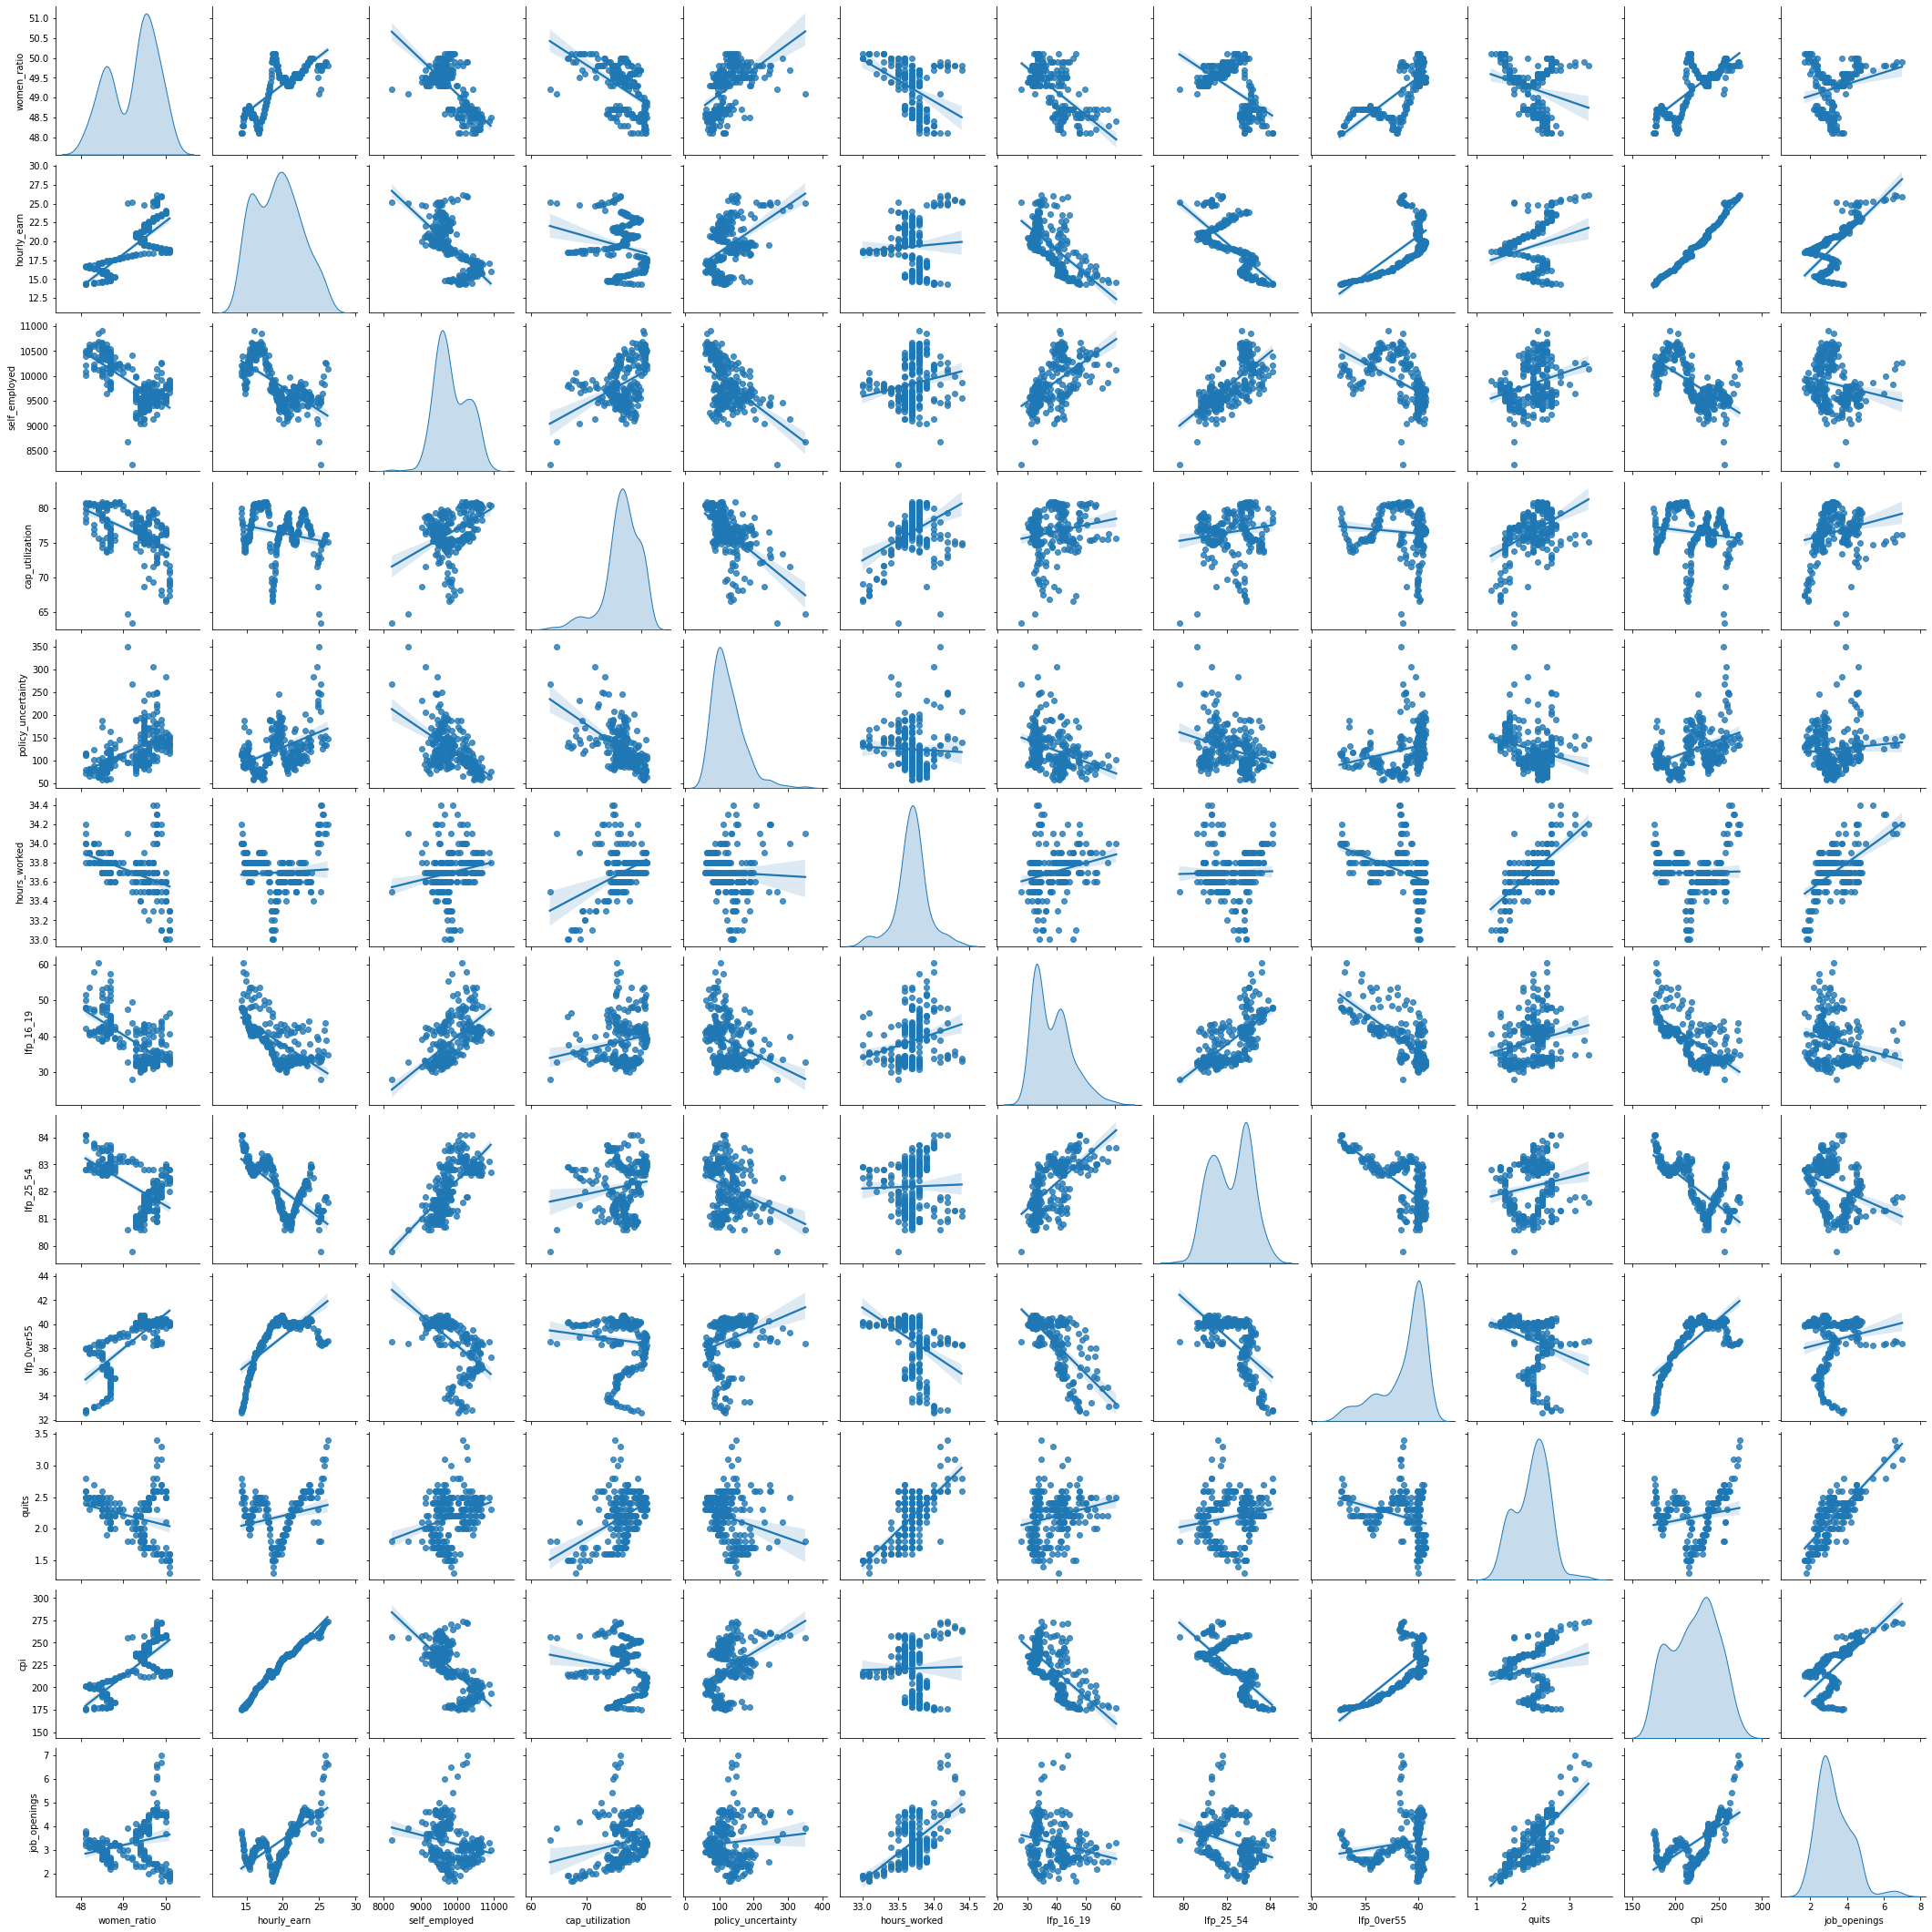

In [286]:
import seaborn as sns
_ = sns.pairplot(table_raw, kind="reg", diag_kind="kde")

#Data Transformation Process

##Adjustments for Skewness
Adjusted for skeweness by testing each variable's skewness and attempted to reduce the skewness by testing the reduction using the natrual log, square root, or inverse square root.

In [265]:
def create_transformed_table(table_raw):
  """
  Function to transform the variables which improve skewness
  args: table_raw (pd.DataFrame)
  returns: table_transformed (pd.DataFrame)
  """
  table_transformed = pd.DataFrame()
  table_transformed['quits'] = table_raw['quits'] #normalizing does not reduce the skewness
  table_transformed['women_ratio'] = table_raw['women_ratio'] #normalizing does not reduce the skewness
  table_transformed['hourly_earn'] = table_raw['hourly_earn'] #normalizing does not reduce the skewness
  table_transformed['lfp_25_54'] = table_raw['lfp_25_54'] #normalizing does not reduce the skewness
  table_transformed['lfp_16_19_inversesqrt'] = 1/np.sqrt(table_raw['lfp_16_19']) #normalizing reduces the skewness
  table_transformed['lfp_0ver55_inversesqrt'] = 1/np.sqrt(table_raw['lfp_0ver55']) #normalizing reduces the skewness
  table_transformed['cap_utilization'] = table_raw['cap_utilization'] #normalizing does not reduce the skewness
  table_transformed['hours_worked'] = table_raw['hours_worked'] #normalizing does not reduce the skewness
  table_transformed['cpi'] = table_raw['cpi'] #normalizing does not reduce the skewness
  table_transformed['self_employed_inversesqrt'] = 1/np.sqrt(table_raw['self_employed']) #normalizing reduces the skewness
  table_transformed['policy_uncertainty_inversesqrt'] = 1/np.sqrt(table_raw['policy_uncertainty']) #normalizing reduces the skewness
  table_transformed['job_openings_inversesqrt'] = 1/np.sqrt(table_raw['job_openings']) #normalizing reduces the skewness
  table_transformed['job_openings'] = table_raw['job_openings'] #normalizing does not reduce the skewness

  return table_transformed

table_transformed = create_transformed_table(table_raw)

In [266]:
def test_skewness(x):
  """
  Function to test the skewness of a series
  args: x Post_Transform class vairable
  """
  skew = 3*(x.mean - x.median)/x.std
  
  return skew

class Post_Transform():
  """
  This class is to provide values for the variables WITH transformation. These values are from the RAW data.
  """
  def __init__(self, series):
    self.std = np.std(series)
    self.median = np.median(series)
    self.mean = np.mean(series)
 

women_ratio_pt = Post_Transform(table_raw['women_ratio']) #normalizing does not reduce the skewness
hourly_earn_pt = Post_Transform(table_raw['hourly_earn']) #normalizing does not reduce the skewness
lfp_25_54_pt = Post_Transform(table_raw['lfp_25_54']) #normalzing does not reduce skewness
lfp_16_19_pt = Post_Transform(table_transformed['lfp_16_19_inversesqrt']) #normalizing reduces the skewness
lfp_0ver55_pt = Post_Transform(table_transformed['lfp_0ver55_inversesqrt']) #normalizing reduces the skewness
cap_utilization_pt = Post_Transform(table_raw['cap_utilization']) #normalizing does not reduce the skewness
hours_worked_pt = Post_Transform(table_raw['hours_worked']) #normalizing does not reduce the skewness
cpi_pt = Post_Transform(table_raw['cpi'])#normalizing does not reduce the skewness
self_employed_pt = Post_Transform(table_transformed['self_employed_inversesqrt']) #normalizing reduces the skewness
policy_uncertainty_pt = Post_Transform(table_transformed['policy_uncertainty_inversesqrt']) #normalizing reduces the skewness
job_openings_inverse_pt = Post_Transform(table_transformed['job_openings_inversesqrt']) #normalizing reduces the skewness
quits_pt = Post_Transform(table_raw['quits']) #normalizing does not reduce the skewness
job_openings_pt = Post_Transform(table_transformed['job_openings'])

test = test_skewness(job_openings_pt)
test2 = test_skewness(job_openings_inverse_pt)
print(test, test2)

0.6195568777103244 -0.05812433442532591


##Standardization

The raw form of these variables (and some normalized with the inverse square root form) require standardization because they are different base sizes (percentages, indexes, and ratios)

The table_final will be a transformed (normalized where skewness could be reduced) and standardized (using min-max scaling)

In [267]:
def standardize_data(series):
  """
  Function to standardize a series of the dataframe.
  formula is Xchanged = (x-mean)/stdev
  args: series (pd.Series) indexed by 'Date'
  returns: stand_series (pd.Series)
  """
  xmin = np.min(series)
  xmax = np.max(series)
  stand_series = []
  for i in series:
    stand_series.append((i-xmin)/(xmax-xmin))
  standardized_series = pd.Series(stand_series)

  return standardized_series


def standardize_table(df):
  """
  Function to standardize a dataframe
  args: df (pd.DataFrame)
  returns: table_standardized (pd.DataFrame)
  """
  table_standardized= pd.DataFrame()
  for column in df.columns[1:]:
      standard = standardize_data(df[f'{column}'])
      table_standardized[f'{column}'] = standard
  table_standardized.reset_index()

  return table_standardized

table_final = standardize_table(table_transformed)
table_final = table_final.dropna()
table_transformed = table_transformed.reset_index()
table_final['quits'] = table_transformed['quits']

#new test values
lfp_16_19_inversesqrt = Test_Values(table_transformed['lfp_16_19_inversesqrt'])
lfp_0ver55_inversesqrt = Test_Values(table_transformed['lfp_0ver55_inversesqrt'])
policy_uncertainty_inversesqrt= Test_Values(table_transformed['policy_uncertainty_inversesqrt'])
job_openings_inversesqrt= Test_Values(table_transformed['job_openings_inversesqrt'])

##Post Transformation

In [269]:
table_final.describe()

,women_ratio,hourly_earn,lfp_25_54,lfp_16_19_inversesqrt,lfp_0ver55_inversesqrt,cap_utilization,hours_worked,cpi,self_employed_inversesqrt,policy_uncertainty_inversesqrt,job_openings_inversesqrt,job_openings,quits
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.568000,0.423784,0.554884,0.560863,0.235525,0.749443,0.498000,0.468812,0.354703,0.512456,0.484670,0.300377,2.184800
std,0.281697,0.262421,0.208851,0.206637,0.255279,0.180618,0.162126,0.265414,0.156384,0.196476,0.194154,0.175766,0.363176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000
25%,0.300000,0.186605,0.372093,0.417208,0.063516,0.676261,0.428571,0.249905,0.222935,0.372829,0.330090,0.169811,1.900000
50%,0.650000,0.430076,0.581395,0.562196,0.085006,0.766929,0.500000,0.500809,0.381292,0.507449,0.488424,0.264151,2.200000
75%,0.800000,0.613943,0.720930,0.747892,0.344336,0.875513,0.571429,0.658962,0.468716,0.642513,0.622645,0.415094,2.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.400000


#Modeling

##Training and Test splits

In [270]:
table_final_TRAIN = table_final[:245]
table_raw_TEST = table_raw[-6:]

##Model

In [271]:
formula = 'quits ~  women_ratio + lfp_25_54 + job_openings_inversesqrt'
model4 = ols(formula = formula, data = table_final_TRAIN)

model_4 = model4.fit(cov_type = 'HAC', cov_kwds = {'maxlags':None}, use_t=True)
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  quits   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     274.0
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           2.38e-77
Time:                        02:14:59   Log-Likelihood:                 174.36
No. Observations:                 245   AIC:                            -340.7
Df Residuals:                     241   BIC:                            -326.7
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [272]:
anova_table3 = sm.stats.anova_lm(model_4, type=2)
print(anova_table3)

                             df     sum_sq  ...            F         PR(>F)
women_ratio                 1.0   3.384829  ...   236.048987   1.341746e-37
lfp_25_54                   1.0   0.013521  ...     0.942914   3.325032e-01
job_openings_inversesqrt    1.0  21.297826  ...  1485.253718  5.067451e-105
Residual                  241.0   3.455824  ...          NaN            NaN

[4 rows x 5 columns]


##De-Transform the Coefs

In [283]:
#women_ratio
coef1 = model_4.params[1]
coef1

-0.20868714845013786

In [284]:
#lfp_25_54
coef2 = model_4.params[2]
coef2

0.6501133114868652

In [285]:
#job_openings_inversesqrt
coef3 = model_4.params[3]
coef3_untransformed = 1/(coef3*coef3)
coef3_untransformed

0.34632536961179344

#Model Validataion
Leave-one-out method

In [280]:
def validation_test2(model,Y,x1,x2,x3, test_number):
  """
  Function to test standardized model with min-max standardization applied.
  For the 3rd variable will de-transform the inverse square root
  args: model (object) , coef (list) 
  returns: estimate (float)
  """
  coefficients = model.params
  Constant = model.params[0]
  coef1 = coefficients[1]
  coef2 = coefficients[2]
  coef3 = coefficients[3]
  if test_number == 1:
    _x1 = coef1 * x1.test_val1
    _x2 = coef2 * x2.test_val1
    _x3 = 1/(coef3*coef3) * x3.test_val1
    _Y = table_raw['quits'].iloc[-5]
  elif test_number == 2:
    _x1 = coef1 * x1.test_val2
    _x2 = coef2 * x2.test_val2
    _x3 = 1/(coef3*coef3) * x3.test_val2
    _Y = table_raw['quits'].iloc[-4]
  elif test_number == 3:
    _x1 = coef1 * x1.test_val3
    _x2 = coef2 * x2.test_val3
    _x3 = 1/(coef3*coef3) * x3.test_val3
    _Y = table_raw['quits'].iloc[-3]
  elif test_number == 4:
    _x1 = coef1 * x1.test_val4
    _x2 = coef2 * x2.test_val4
    _x3 = 1/(coef3*coef3) * x3.test_val4
    _Y = table_raw['quits'].iloc[-2]
  elif test_number == 5:
    _x1 = coef1 * x1.test_val5
    _x2 = coef2 * x2.test_val5
    _x3 = 1/(coef3*coef3) * x3.test_val5
    _Y = table_raw['quits'].iloc[-1]

  estimate = _x1 + _x2 + _x3 + Constant
  actual = _Y
  accuracy = 1-(np.abs((estimate-actual)/actual))

  return estimate, actual, accuracy

def results_table(model, Y, x1, x2, x3):
  """
  Function to create a dataframe of the estimates, actuals and results for 5 tests
  """
  model_validation = pd.DataFrame(columns = ['Test', 'Estimate', 'Actual', 'Accuracy'])
  count = 1
  estimate_list = []
  actual_list = []
  accuracy_list = []
  test_list = []
  while count <=5:
    estimate, actual, accuracy = validation_test2(model, Y, x1, x2, x3, count)
    estimate_list.append(estimate)
    actual_list.append(actual)
    accuracy_list.append(accuracy)
    test_list.append(count)
    count +=1

  model_validation['Test'] = test_list
  model_validation['Estimate'] = estimate_list
  model_validation['Actual'] = actual_list
  model_validation['Accuracy'] = accuracy_list

  return model_validation



df = results_table(model_4, quits, women_ratio, lfp_25_54, job_openings)
final_accuracy = (df['Accuracy'].sum())/5


print("Average Accuracy: %0.2f" % (final_accuracy*100),"%")
print('Test Table Details:')
display(df)

Average Accuracy: 89.60 %
Test Table Details:


,Test,Estimate,Actual,Accuracy
0,1,2.794473,2.8,0.998026
1,2,3.158416,3.0,0.947195
2,3,2.977146,3.1,0.960370
3,4,2.655943,3.3,0.804831
4,5,2.616054,3.4,0.769428
